##Libraries

In [ ]:
# Installing the needed libraries
import cv2
import numpy as np
import tifffile as tiff
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from google.colab.patches import cv2_imshow

from keras.metrics import MeanSquaredError

import glob
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# For results
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

"""#For optimizing the hyperparameters if time is for it
!pip install scikeras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV"""

'#For optimizing the hyperparameters if time is for it\n!pip install scikeras\nfrom scikeras.wrappers import KerasClassifier\nfrom sklearn.model_selection import GridSearchCV'

##Mounting the drives and image

In [ ]:
main_folder_path = "/content/drive/MyDrive/OneDrive_1_08-11-2023"
raw_data_list = []
segmented_labels_list = []

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data
data_folder_path = os.path.join(main_folder_path, 'data')
for filename in os.listdir(data_folder_path):

        file_path = os.path.join(data_folder_path, filename)
        raw_data = tiff.imread(file_path)
        raw_data_list.append(raw_data)

In [ ]:
# Load labels
labels_folder_path = os.path.join(main_folder_path, 'labels')
for filename in os.listdir(labels_folder_path):

        file_path = os.path.join(labels_folder_path, filename)
        segmented_labels = tiff.imread(file_path)
        segmented_labels_list.append(segmented_labels)

In [ ]:
# lists to np array
raw_data = np.array(raw_data_list)
segmented_labels = np.array(segmented_labels_list)

#normalize
normalized_raw_data = raw_data.astype(np.float32) / np.max(raw_data)

In [ ]:
path = "/content/drive/MyDrive/OneDrive_1_08-11-2023"
train_path = "/content/drive/MyDrive/OneDrive_1_08-11-2023/data" #path to get the masks and tissue image of to import photos from gdrive
labels_path = "/content/drive/MyDrive/OneDrive_1_08-11-2023/labels"
image_size = 256 #resized image size
batch_size = 3
epochs = 10

# training and test Ids
train_data_ids = next(os.walk("/content/drive/MyDrive/OneDrive_1_08-11-2023/data"))[2] #path to get the masks and tissue image of to import photos from gdrive
train_label_ids = next(os.walk("/content/drive/MyDrive/OneDrive_1_08-11-2023/labels"))[2]
# deciding size of validation data
val_data_size = 50
val_label_size = 50

valid_data_ids = train_data_ids[:2*val_data_size] # list of validation ids
train_data_ids = train_data_ids[2*val_data_size:] # list of training ids
test_data_ids = valid_data_ids[:val_data_size]
valid_data_ids = valid_data_ids[val_data_size:]

# valid_label_ids = train_label_ids[:2*val_label_size] # list of validation ids
# train_label_ids = train_label_ids[2*val_label_size:] # list of training ids
# test_label_ids = valid_label_ids[:val_label_size]
# valid_label_ids = valid_label_ids[val_label_size:]

In [ ]:
tid1 = 'slice__'+ train_data_ids[1][9:-1]
tid1

'slice__108.tif'

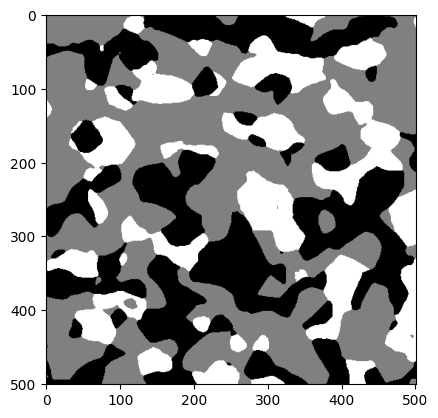

In [ ]:
image_path = path + "/labels/" + tid1
timage2 = cv2.imread(image_path, 1)
plt.imshow(timage2, cmap='gray')

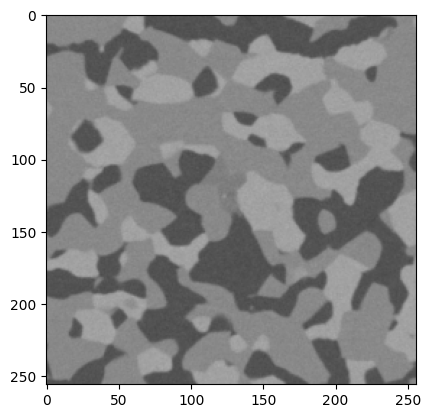

In [ ]:
image_path = path + "/data/" + train_data_ids[1]
timage1 = cv2.imread(image_path, 1)
t2 = cv2.resize(timage1, (256, 256))
plt.imshow(t2, cmap='gray')

In [ ]:
class DataGen(keras.utils.Sequence): #class for data generation
    def __init__(self, ids, path, batch_size=8, image_size=256):
        self.ids = ids #ids of images
        self.path = path #path to ids
        self.batch_size = batch_size #szie of the batch from all the images
        self.image_size = image_size #size of the image
        self.on_epoch_end()

    def __load__(self, id_name): #function to load a image from given id
        image_path = self.path + "/data/" + id_name #from the given link going to Tssue-images folder
        mask_path = self.path + "/labels/" + 'slice__'+ id_name[9:-1] #from given link to Binary-Mask folder

        ## Reading Image
        image = cv2.imread(image_path, 1) #reading color image
        image = cv2.resize(image, (self.image_size, self.image_size)) #resize to defined value

        mask = cv2.imread(mask_path, 0) #reading balckNwhite
        #mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = np.expand_dims(cv2.resize(mask, (self.image_size, self.image_size)), axis=-1) #xpanding dims to match with image

        ## Normalizaing
        image = image/255.0
        mask = mask/255.0

        return image, mask

    def __getitem__(self, index): #importing images in batch
        if(index+1)*self.batch_size > len(self.ids): #condition if total is images are not multiple of batch_size
            self.batch_size = len(self.ids) - index*self.batch_size

        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]

        image = [] #empty list in which 1 batch of images will be stored
        mask  = []

        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [ ]:
segmented_labels.shape

(500, 501, 501)

(3, 256, 256, 3) (3, 256, 256, 1)


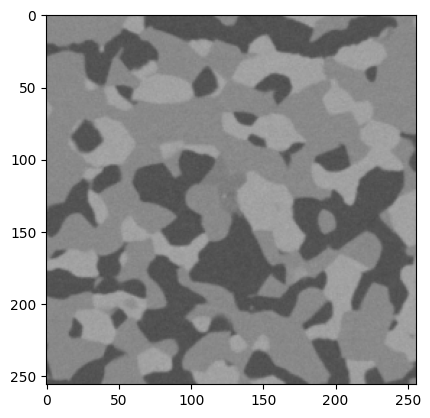

In [ ]:
train_gen = DataGen(train_data_ids, path, batch_size=batch_size, image_size=image_size) #genrating data for training
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)
plt.imshow(x[1], cmap='gray')

In [ ]:
"""image_index = 110  # Change this to the index of the image you want to view other images

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.imshow(normalized_raw_data[image_index], cmap='gray')
plt.title("Raw image")

plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_labels[image_index], cmap='gray')
plt.title("Segmented Image")
plt.axis('off')
plt.show()"""

'image_index = 110  # Change this to the index of the image you want to view other images\n\nplt.figure(figsize=(8, 8))\nplt.subplot(1, 2, 1)\nplt.imshow(normalized_raw_data[image_index], cmap=\'gray\')\nplt.title("Raw image")\n\nplt.axis(\'off\')\nplt.subplot(1, 2, 2)\nplt.imshow(segmented_labels[image_index], cmap=\'gray\')\nplt.title("Segmented Image")\nplt.axis(\'off\')\nplt.show()'

In [ ]:
# from sklearn.model_selection import train_test_split

# # 80-10-10 train, val, test


# random_seed = 42

# # Split the data into training, validation, and test sets
# train_data, test_data, train_labels, test_labels = train_test_split(
#     normalized_raw_data, segmented_labels, test_size=0.2, random_state=random_seed)

# test_data, val_data, test_labels, val_labels = train_test_split(
#     test_data, test_labels, test_size=0.5, random_state=random_seed)

# #  'train_data' and 'train_labels' for training model,
# # 'val_data' and 'val_labels' for validation, and 'test_data' and 'test_labels' for evaluation.


In [ ]:
# train_labels.shape

In [ ]:
# def resize_images(images, target_size):
#     resized_images = []
#     for img in images:
#         resized_img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)
#         resized_images.append(resized_img)
#     return np.array(resized_images)

# image_size=256
# target_size = (image_size, image_size)

# resized_train_data = resize_images(train_data, target_size)
# resized_train_labels = resize_images(train_labels, target_size)

# resized_val_data = resize_images(val_data, target_size)
# resized_val_labels = resize_images(val_labels, target_size)

# resized_test_data = resize_images(test_data, target_size)
# resized_test_labels = resize_images(test_labels, target_size)



In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1): #block for contracting/downsampling part of Unet
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):#block for uplsampling part
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1): # block for bottleneck
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [ ]:
def UNet(): #defing the model
    f = [16, 32, 64, 128, 256, 512] #filter size array from this list no. of filters will taken as parameter in block
    inputs = keras.layers.Input((image_size, image_size, 3)) #input layer

    p0 = inputs
    #now variable no. of block with varible no. of filters can be tried to get better accuracy
    c1, p1 = down_block(p0, f[0]) #img_size -> img_size/2
    c2, p2 = down_block(p1, f[1]) #--> img_size/4
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3])
    c5, p5 = down_block(p4, f[4])
    # c6, p6 = down_block(p5, f[5])

    bn = bottleneck(p5, f[5])
    # u = up_block(bn, c6, f[5])
    u0 = up_block(bn, c5, f[4])
    u1 = up_block(u0, c4, f[3])
    u2 = up_block(u1, c3, f[2])
    u3 = up_block(u2, c2, f[1]) #-->img_size/2
    u4 = up_block(u3, c1, f[0]) #img_size/2 -> img_size
    # u1 = up_block(bn, c4, f[3])
    # u2 = up_block(u1, c3, f[2])
    # u3 = up_block(u2, c2, f[1]) #-->img_size/2
    # u4 = up_block(u3, c1, f[0]) #img_size/2 -> img_size

    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4) #output layer with signmoid activation
    model = keras.models.Model(inputs, outputs) #creating a model

    return model

In [ ]:
#loss function

def dice_coefficient(y_true, y_pred): #frun to calculate dice_coeff
    smooth = 1e-6 #variable so that term don't be in form 0/0
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true)) + tf.reduce_sum(tf.square(y_pred)) + smooth)
    return score

def dice_loss(y_true, y_pred): #final loss using coeff
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

# def dice_loss(y_true, y_pred):
#   y_true = tf.cast(y_true, tf.float32)
#   y_pred = tf.math.sigmoid(y_pred)
#   numerator = 2 * tf.reduce_sum(y_true * y_pred)
#   denominator = tf.reduce_sum(y_true + y_pred)

#   return 1 - numerator / denominator

In [ ]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

In [ ]:
def custom_mse(y_true, y_pred):

    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse

def quantized_mse(y_true, y_pred):

    quantized_pred = tf.where(y_pred < 0.25, 0.0, tf.where(y_pred < 0.75, 0.5, 1.0))
    quantized_true = tf.where(y_true < 0.25, 0.0, tf.where(y_true < 0.75, 0.5, 1.0))

    mse = custom_mse(quantized_true, quantized_pred)
    return 100*(1-mse)

In [ ]:

model = UNet() #intializing model
model.compile(optimizer="adam", loss=DiceLoss(), metrics=[dice_coefficient, quantized_mse]) #compling using dice_loss ,
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
batch_size = 4
epochs = 10

train_gen = DataGen(train_data_ids, path, image_size=image_size, batch_size=batch_size) #generating training data
valid_gen = DataGen(valid_data_ids, path, image_size=image_size, batch_size=batch_size) #genrating validation data

train_steps = len(train_gen) #train step for training data
valid_steps = len(valid_gen) #batch step for validing data

history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/10
100/100 [==============================] - 29s 97ms/step - loss: 0.1315 - dice_coefficient: 0.8685 - quantized_mse: 87.2680 - val_loss: 0.0466 - val_dice_coefficient: 0.9534 - val_quantized_mse: 96.6383
Epoch 2/10
100/100 [==============================] - 6s 62ms/step - loss: 0.0217 - dice_coefficient: 0.9783 - quantized_mse: 98.1989 - val_loss: 0.0125 - val_dice_coefficient: 0.9875 - val_quantized_mse: 98.5911
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 0.0146 - dice_coefficient: 0.9854 - quantized_mse: 98.6363 - val_loss: 0.0163 - val_dice_coefficient: 0.9837 - val_quantized_mse: 98.8548
Epoch 4/10
100/100 [==============================] - 6s 62ms/step - loss: 0.0105 - dice_coefficient: 0.9895 - quantized_mse: 99.0564 - val_loss: 0.0070 - val_dice_coefficient: 0.9930 - val_quantized_mse: 99.3105
Epoch 5/10
100/100 [==============================] - 7s 63ms/step - loss: 0.0066 - dice_coefficient: 0.9934 - quantized_mse: 99.3189 - val_loss: 0

1/1 [==============================] - 1s 597ms/step


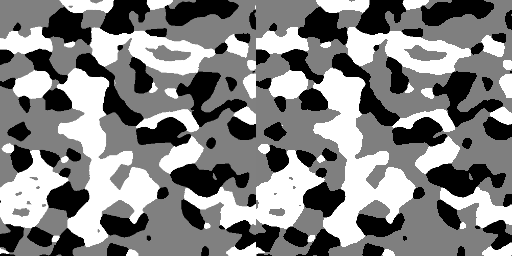

In [ ]:
model.save_weights("UNetW.h5") #saving weights of model

## Dataset for prediction
x1, y1 = valid_gen.__getitem__(1) #image and mask of validation dataset
result1 = model.predict(x1) #result of prediction

#result1 = result1 > 0.65 # putting threshold to get binary image
threshold1 = 0.25
threshold2 = 0.75

# Quantize array
quantized_arr = np.zeros_like(result1)
quantized_arr[result1 <= threshold1] = 0
quantized_arr[(result1 > threshold1) & (result1 <= threshold2)] = 0.5
quantized_arr[result1 > threshold2] = 1


#showing mask predection for validation image
cv2_imshow(np.hstack([255*y1[0], 255*quantized_arr[0]])) #write one is original mask and left is predection

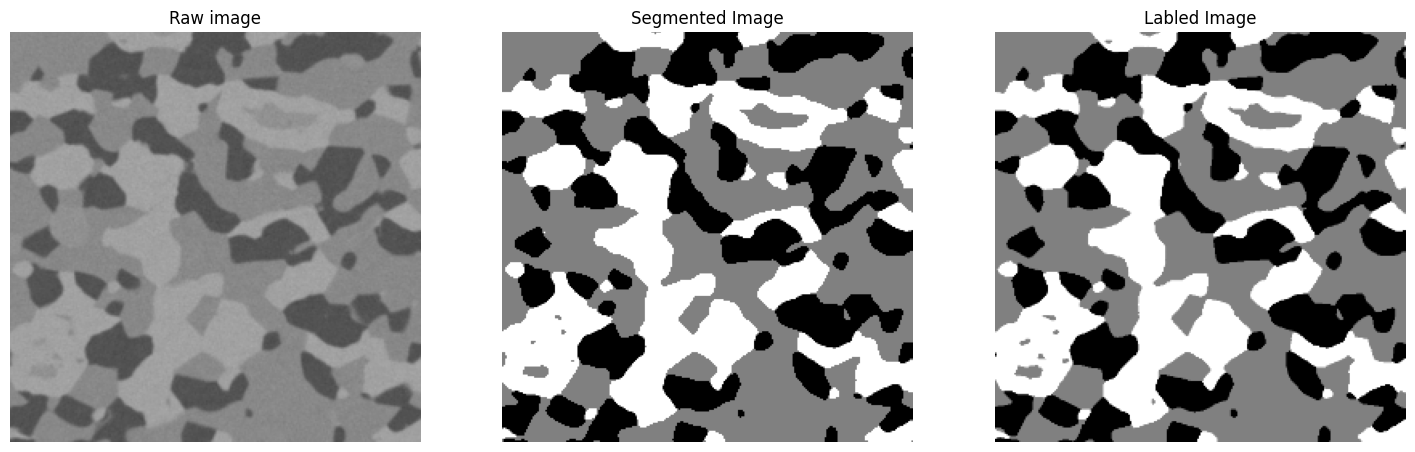

In [ ]:
plt.figure(figsize=(18, 18))
plt.subplot(1, 3, 1)
plt.imshow(x1[0], cmap='gray')
plt.title("Raw image")

plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(quantized_arr[0], cmap='gray')
plt.title("Segmented Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(y1[0], cmap='gray')
plt.title("Labled Image")
plt.axis('off')

plt.show()

In [ ]:
import math
from sklearn.metrics import mean_squared_error



def error(label, pic):
  return np.sqrt(np.mean((label-pic)**2))

In [ ]:
error(quantized_arr[0], y1[0])

0.057752455640081406

In [ ]:
quantized_arr[0].shape

(256, 256, 1)

In [ ]:
y1[0].shape

(256, 256, 1)

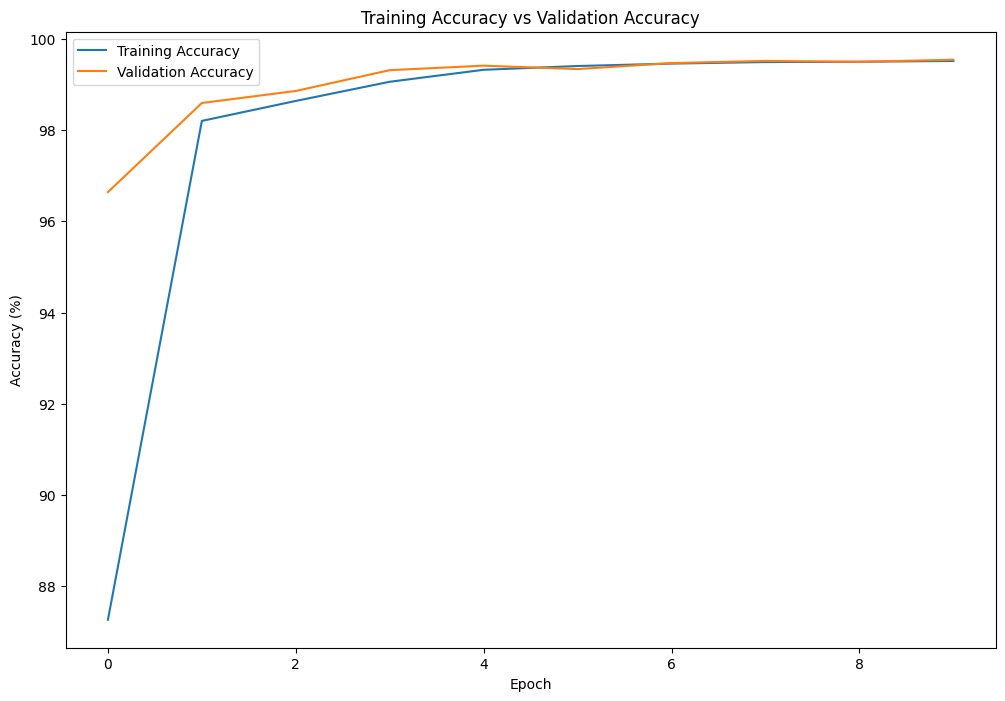

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(12, 8))

plt.plot(history.history['quantized_mse'], label='Training Accuracy')
plt.plot(history.history['val_quantized_mse'], label='Validation Accuracy')

plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()

plt.show()

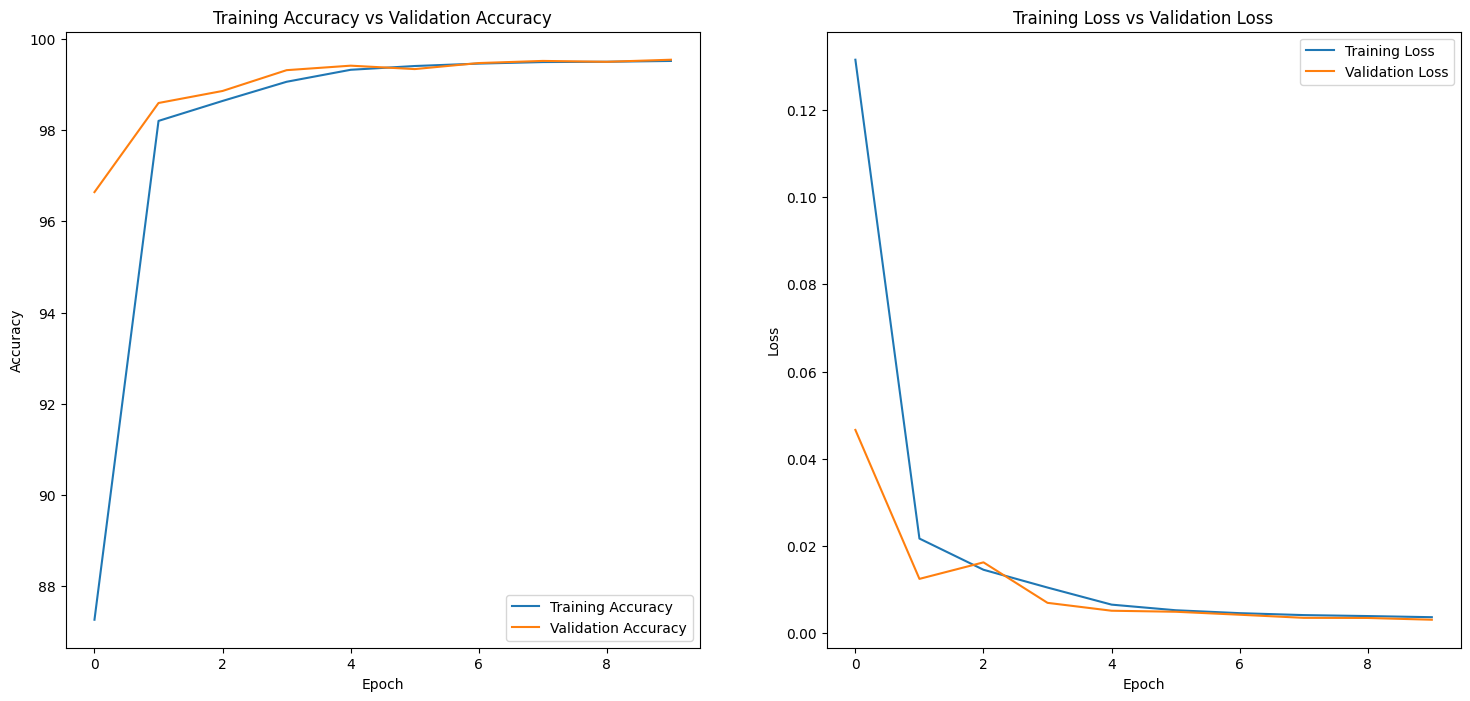

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Plotting accuracy
axes[0].plot(history.history['quantized_mse'], label='Training Accuracy')
axes[0].plot(history.history['val_quantized_mse'], label='Validation Accuracy')
axes[0].set_title('Training Accuracy vs Validation Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend()

# Plotting loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training Loss vs Validation Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend()

plt.show()

1/1 [==============================] - 1s 798ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


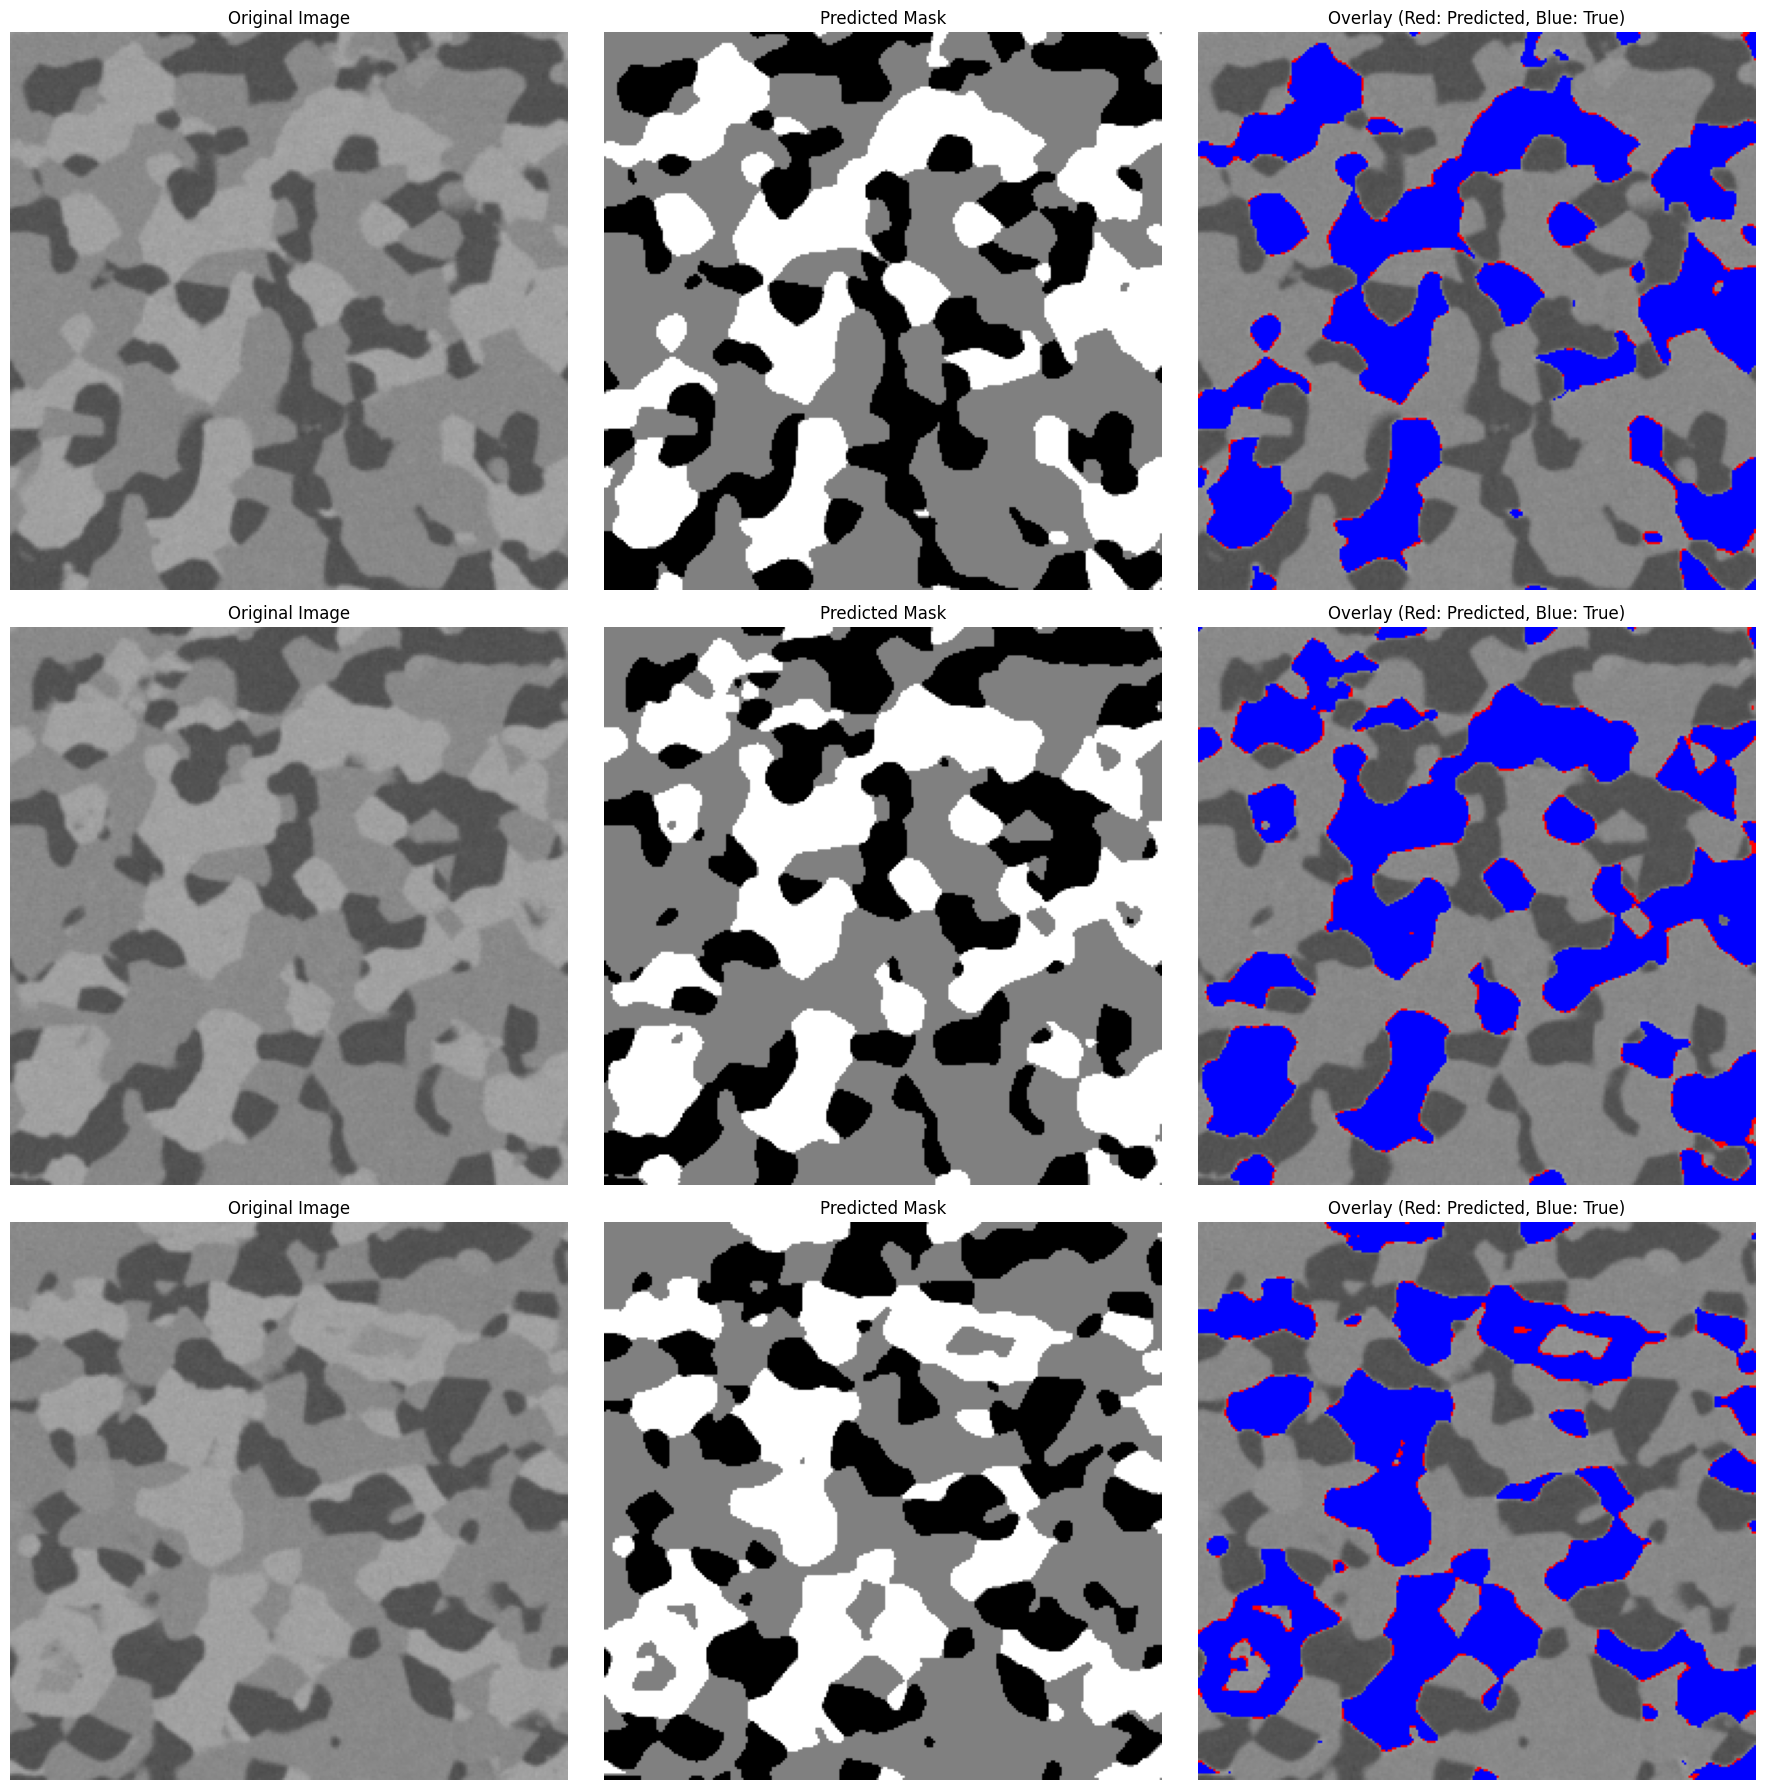

In [ ]:
# Function to overlay masks on original images
def overlay_masks(raw_image, segmented_mask, label_mask, alpha=0.5):
    overlay = raw_image.copy()
    overlay[segmented_mask == 1] = [255* alpha, 0, 0]  # Red for predicted regions
    overlay[label_mask == 1] = [0, 0, 255*alpha]  # Blue for true regions
    return overlay

# Function to plot histogram
def plot_histogram(image, title):
    plt.figure(figsize=(8, 4))
    plt.hist(image.flatten(), bins=256, range=[0,256], color='r', alpha=0.5)
    plt.title(title)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

# Function to choose and compare multiple predictions
def compare_predictions(num_samples, test_gen, model):
    plt.figure(figsize=(18, num_samples * 6))

    for i in range(num_samples):
        random_index = random.randint(0, len(test_gen) - 1)
        sample_data = test_gen.ids[random_index]

        # Load sample image and mask
        sample_image, sample_mask = test_gen.__load__(sample_data)

        # Predict on the sample image
        sample_prediction = model.predict(np.expand_dims(sample_image, axis=0))


        threshold1 = 0.25
        threshold2 = 0.75

        # Quantize array
        quantized_arr = np.zeros_like(sample_prediction)
        quantized_arr[sample_prediction <= threshold1] = 0
        quantized_arr[(sample_prediction > threshold1) & (sample_prediction <= threshold2)] = 0.5
        quantized_arr[sample_prediction > threshold2] = 1
        # Threshold the prediction
        # threshold = 0.5
        # sample_prediction = (sample_prediction > threshold).astype(np.uint8)

        # Overlay masks on original image
        overlay = overlay_masks(sample_image, quantized_arr[0, :, :, 0], sample_mask[:, :, 0], alpha=0.3)

        # Plotting
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(sample_image, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(quantized_arr[0, :, :, 0], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(overlay)
        plt.title("Overlay (Red: Predicted, Blue: True)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize Overlay of Masks on Original TIFF Images
test_gen = valid_gen
x1, y1 = test_gen.__getitem__(1)
result1 = model.predict(x1)

threshold1 = 0.25
threshold2 = 0.75

# Quantize array
quantized_arr = np.zeros_like(result1)
quantized_arr[result1 <= threshold1] = 0
quantized_arr[(result1 > threshold1) & (result1 <= threshold2)] = 0.5
quantized_arr[result1 > threshold2] = 1




# num_samples_overlay = 3  # Adjust the number of samples to visualize
# for i in range(num_samples_overlay):
#     random_index = random.randint(0, len(test_gen) - 1)
#     sample_data = test_gen.ids[random_index]
#     sample_image, sample_mask = test_gen.__load__(sample_data)
#     overlay = overlay_masks(sample_image, predicted_masks[i, :, :, 0], sample_mask[:, :, 0])

#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 3, 1)
#     plt.imshow(sample_image, cmap='gray')
#     plt.title("Raw Image")
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(predicted_masks[i, :, :, 0], cmap='gray')
#     plt.title("Segmented Mask")
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(overlay)
#     plt.title("Overlay (Red: Predicted, Blue: True)")
#     plt.axis('off')

#     plt.show()

# """# Histogram Analysis
# plot_histogram(x1[0], "Raw Image Histogram")
# plot_histogram(predicted_masks[0, :, :, 0], "Segmented Mask Histogram")"""

# Compare Multiple Predictions
num_samples_compare = 3  # You can adjust the number of samples to compare
compare_predictions(num_samples_compare, test_gen, model)


In [ ]:
# Initialize lists for true and predicted labels
y_true = []
y_pred = []

# Evaluate on test data
for i in range(len(test_gen)):
    x_test, y_test = test_gen[i]
    predictions = model.predict(x_test)

    # Threshold the ground truth and predictions to binary values
    y_test_binary = (y_test > 0.5).astype(int)
    predictions_binary = (predictions > 0.5).astype(int)

    y_true.extend(y_test_binary.flatten())
    y_pred.extend(predictions_binary.flatten())

# Calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Display confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Display quantitative performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

1/1 [==============================] - 0s 26ms/step


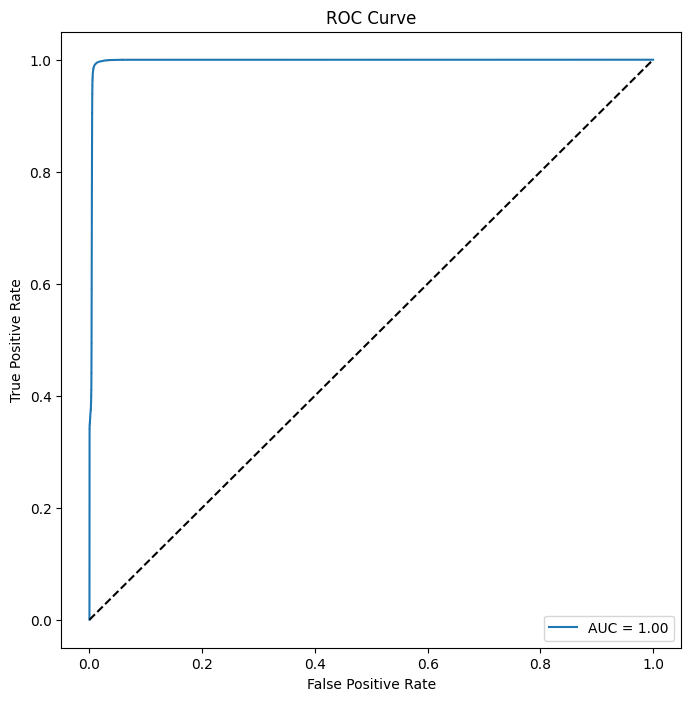

AUC Score: 0.9972
Really, a perfect learner...


In [ ]:
# Assuming predictions are probabilities from your model
y_prob = model.predict(x_test).flatten()
y_true = (y_test > 0.5).astype(int).flatten()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_true, y_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f'AUC Score: {auc_score:.4f}')
print(f'Really, a perfect learner...')